# Algoritmos de detección de comunidades

En este cuaderno, se resolverá el [TPC04 - Comunidades](https://drive.google.com/file/d/1Y2JZm1qU4wPx8hfExzn9kQaQWFDB2ngB/view). En el mismo se podrán leer los resultados de los ejercicios, el código implementado para la resolución y comentarios sobre las tareas realizadas.

[Aquí un enlace para descargar los datos](http://materias.df.uba.ar/scytda2020c1/files/2020/04/TC04_ComunidadesData.zip). Para poder ejecutar el archivo, deben estar subidos al directorio del cuaderno donde se lo abre para poder cargarlo. 

Importamos librerías generales a utilizar.

In [1]:
import networkx as nx # Para redes en general
import community as community_louvain 
import igraph as ig 
import matplotlib.pylab as plt # Para graficar 
import matplotlib.cm as cm # para mapas de colores
import numpy as np
import cairo 
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score as info_mutua #ejercicio 1c
from itertools import combinations #combinaciones 
from collections import defaultdict #crear diccionarios sin KeyError
import scipy.stats as stats #Método Fisher Ejercicio 1d
import matplotlib.cm as cm # para mapas de colores
from collections import Counter # para contar ocurrencias en un dict

# Ejercicio 1

## Inciso (a)

la partición en comunidades de esta red utilizando la metodología Louvain, infomap,
fast_greedy y edge_betweenness. Visualice los resultados gráficamente.

Cargamos la red de delfines y la definimos también en iGraph.

In [2]:
Red_delfines = nx.read_gml('./data/dolphins.gml')
posiciones = nx.kamada_kawai_layout(Red_delfines)

Red_delfines_igraph = ig.Graph.TupleList(Red_delfines.edges(), directed=False)

Hacemos un diccionario con los géneros guardados en el archivo .txt

In [3]:
def gend_dict(filename):      
    g_dict = {}
    with open(filename) as f:
        for line in f:
            data = line.strip().split()
            key = data[0]
            data = data[1]
            g_dict[key] = data

    return g_dict

gender_dict = gend_dict('./data/dolphinsGender.txt')

Codificamos el género con una "shape" a ser graficada. 

In [4]:
shape_dict = {}
for nodo in Red_delfines.nodes(): 
    if gender_dict[nodo] == 'm':
        shape_dict[nodo] = 's' 
    if gender_dict[nodo] == 'f':
        shape_dict[nodo] = '*' 
    if gender_dict[nodo] == 'NA':
        shape_dict[nodo] = '^'
nx.set_node_attributes(Red_delfines, shape_dict, 'shape')

shapes = set([nodo[1]['shape'] for nodo in Red_delfines.nodes(data = True)])

Para tener todo en el mismo formato necesitamos convertir las redes de iGraph a diccionario.

In [5]:
# función que toma la Red de igraph y la partición calculada con Igraph, y la devuelve como diccionario
def convertir_particion_igraph_a_diccionario(Red_igraph,particion_igraph):
    particion_dict = {}
    for cluster in range(len(particion_igraph)):
        for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
            particion_dict.update({nodo:cluster})
    return particion_dict

def convertir_dict_a_lista(dict):
    categoria = set(dict.values())
    particiones = []
    for n in categoria:
        cluster = [k for k in dict.keys() if dict[k] == n]
        particiones.append(cluster)
    return particiones_louvline

Para graficar vamos a elegir colores para cada comunidad. 

In [6]:
#devuelve una lista de n colores hex
import random
def colores_hex(n):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(n)]
    return color

Meme para que completen :) 

<img src="data/meme.jpg" width="500">

Creamos funciones para calcular las particiones. Edge Betweenness e Infomap requieren pasarlas a iGraph.

In [7]:
# devuelve particiones con Edge Betweenness
def edge_betweenness(Red): 
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    dendograma_edge_betweenness = Red_igraph.community_edge_betweenness(directed=False, weights=None)
    particiones_edge_betweenness = dendograma_edge_betweenness.as_clustering()
    dict_particiones_edge_betweenness = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_edge_betweenness)
    return dict_particiones_edge_betweenness

#devuelve particiones con Fast Greedy
def fast_greedy(Red):
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    dendograma_fast_greedy = Red_igraph.community_fastgreedy(weights=None)
    particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
    dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_fast_greedy)
    return dict_particiones_fast_greedy

#particiones con Louvline
def louvile(Red):
    dict_particiones_louvline = community_louvain.best_partition(Red, random_state = 42)
    return dict_particiones_louvline


#particiones con infomap
def infomap(Red):
    Red_igraph = ig.Graph.TupleList(Red.edges(), directed=False) #la paso a igraph
    particiones_infomap = Red_igraph.community_infomap()
    dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_igraph,particiones_infomap)
    return dict_particiones_infomap

Calculamos las particiones y las guardamos en un diccionario.

In [8]:
particiones = {}
particiones['Edge_bet'] = edge_betweenness(Red_delfines)
particiones['Fast_greedy'] = fast_greedy(Red_delfines)
particiones['Louvline'] = louvile(Red_delfines)
particiones['Infomap'] = infomap(Red_delfines)

print(particiones['Louvline'])

{'Beak': 0, 'Beescratch': 1, 'Bumper': 0, 'CCL': 2, 'Cross': 3, 'DN16': 1, 'DN21': 1, 'DN63': 0, 'Double': 2, 'Feather': 1, 'Fish': 0, 'Five': 3, 'Fork': 4, 'Gallatin': 1, 'Grin': 4, 'Haecksel': 3, 'Hook': 4, 'Jet': 1, 'Jonah': 3, 'Knit': 0, 'Kringel': 2, 'MN105': 3, 'MN23': 1, 'MN60': 3, 'MN83': 3, 'Mus': 1, 'Notch': 1, 'Number1': 1, 'Oscar': 2, 'Patchback': 3, 'PL': 0, 'Quasi': 1, 'Ripplefluke': 1, 'Scabs': 4, 'Shmuddel': 4, 'SMN5': 3, 'SN100': 2, 'SN4': 4, 'SN63': 4, 'SN89': 2, 'SN9': 4, 'SN90': 1, 'SN96': 0, 'Stripes': 4, 'Thumper': 4, 'Topless': 3, 'TR120': 4, 'TR77': 0, 'TR82': 1, 'TR88': 4, 'TR99': 4, 'Trigger': 3, 'TSN103': 4, 'TSN83': 4, 'Upbang': 1, 'Vau': 3, 'Wave': 1, 'Web': 1, 'Whitetip': 4, 'Zap': 2, 'Zig': 1, 'Zipfel': 4}


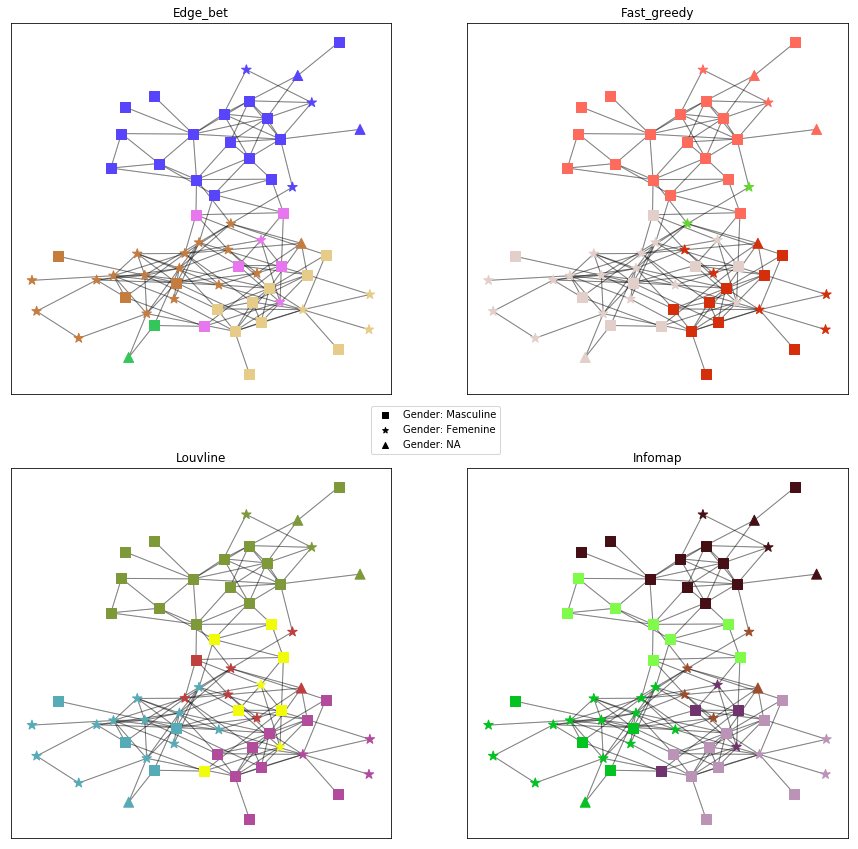

In [9]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    colores = colores_hex(max(particion.values())+1) #funcion que devuelve n colores

    node_color_dict = {}
    for node in Red_delfines.nodes():
        node_color_dict[node] = colores[particion[node]]
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        #nx.draw(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_nodes(Red_delfines,node_size= 100, ax = axs[i], node_color=node_color,pos=posiciones,node_shape = aShape,  nodelist = node_list)
        nx.draw_networkx_edges(Red_delfines, ax = axs[i], width=1.0, alpha=0.2,pos=posiciones)
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(0.1, 1.18))
plt.show()

A las particiones según cada método le agregamos forma a cada nodo según su género. 

## Inciso (b)
La modularidad es un escalar que se define como la diferencia entre la cantidad de enlaces que unen nodos de la misma clase para una red dada, y la cantidad esperada de dichos enlaces en una red aleatoria con la misma distribución de grado. De esta manera, valores positivos de la modularidad indican que existe clustering entre los nodos pertenecientes a una misma clase en la red, mientras que valores negativos indican la situación contraria.

Es importante notar que los algoritmos utilizados en el inciso anterior se basan en elegir una clasifcación que maximice la modularidad, partiendo de una red que no posee clasificación alguna. Es por ello que, por construcción, todas las particiones obtenidas a partir de dicho proceso tendrán modularidad positiva.

En la siguiente tabla se muestran los valores obtenidos para la modularidad Q

In [10]:
Coeficientes = {}
for i,metodo in enumerate(particiones):
    particion = particiones[metodo]
    mod = community_louvain.modularity(particion,Red_delfines)
    Coeficientes[metodo] = {}
    Coeficientes[metodo]['Modularidad'] = mod

df_modularidad = pd.DataFrame(Coeficientes)
df_modularidad.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Modularidad,0.519,0.492,0.524,0.519


Otra cantidad que permite medir el grado de agrupamiento en comunidades de una red
es el coeficiente de silouhette, que cuantifica la diferencia entre la distancia mínima de un nodo dado a un
nodo de una comunidad distinta a la suya y la distancia media de dicho nodo al resto de los
nodos de su comunidad.  

In [11]:
def Silhouette(Red,particion): # La función nos pide la Red y la partición como diccionario
    S=[]
    limites=[0]
  
    # Recorro los clusters sin repetir
    for cluster in set(particion.values()): 
    #Filtro los nodos que pertenecen a este cluster
        nodos_en_cluster = [nodo for (nodo, value) in particion.items() if value == cluster] 
        S_cluster=[]
    # Recorro los nodos del cluster
        for nodo in nodos_en_cluster:
            distancias_dentro=[]
            distancias_fuera=[]
            
            # Recorro los nodos del mismo cluster
            for nodo_en_cluster in nodos_en_cluster:
                if nodo != nodo_en_cluster:
                  # Calculo y guardo la distancia, si no es consigo mismo
                  distancias_dentro.append(nx.shortest_path_length(Red, source=nodo, target=nodo_en_cluster, weight=None))
            
            # Recorro los nodos de los otros clusters
            for nodo_fuera in Red.nodes():
                if particion[nodo_fuera] != cluster:
                  # Calculo y guardo la distancia
                  distancias_fuera.append(nx.shortest_path_length(Red, source=nodo, target=nodo_fuera, weight=None)) 
            
            # Calculo la distancia media para los del mismo cluster
            if distancias_dentro == []:
                distancia_media_dentro = 0
            else:
                distancia_media_dentro=np.mean(distancias_dentro)
             # Calculo la distancia mínima para los nodos fuera del cluster
            if distancias_fuera == []:
                distancia_min_fuera = 0
            else:
                distancia_min_fuera=np.min(distancias_fuera)
                
            # Calculo y guardo la Silhouette del nodo
            S_cluster.append((distancia_min_fuera-distancia_media_dentro)/np.max([distancia_min_fuera,distancia_media_dentro]))
        
        # Ordeno las Silhouette del mismo cluster por valor, para graficar lindo
        S_cluster=sorted(S_cluster)
        # Me guardo en qué nodo termina cada cluster, para graficar clusters por colores
        limites.append(len(S_cluster)+limites[-1])
        # Agrego las Silhouette de este cluster a la lista de todas
        S = S + S_cluster
        # Calculo la Silhouette media
    S_media = np.mean(S)

    return S,S_media,limites

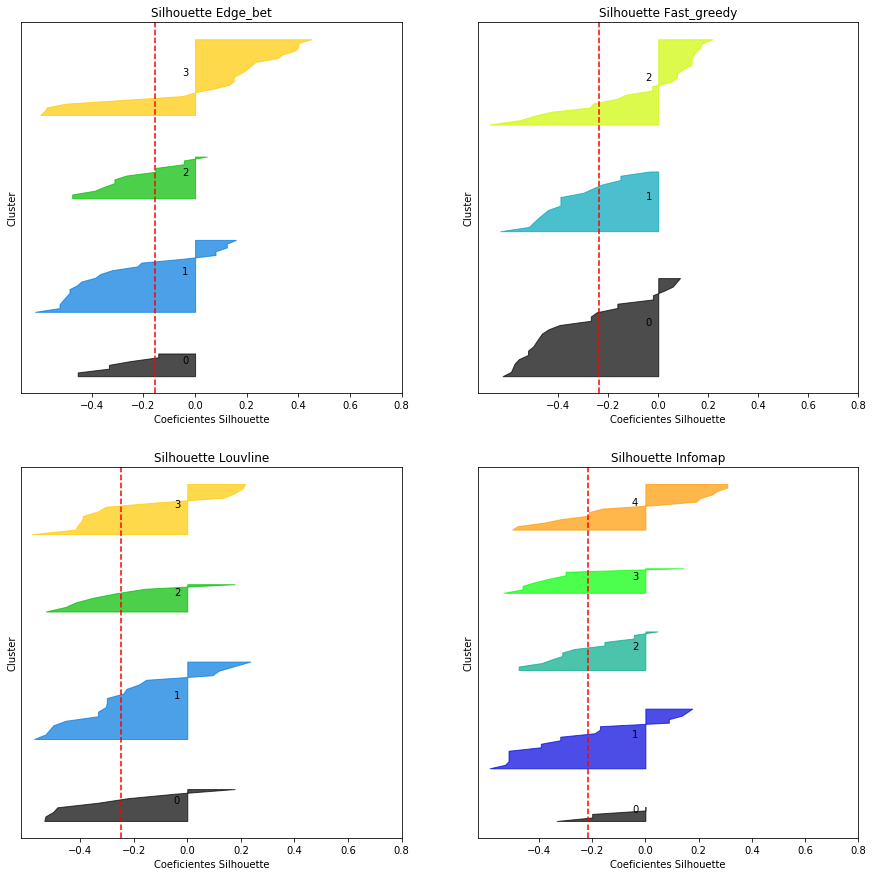

In [12]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for n,metodo in enumerate(particiones):
    particion = particiones[metodo]
    sample_silhouette_values,silhouette_avg,limites = Silhouette(Red_delfines,particion)
    Coeficientes[metodo]['Silhouette'] = silhouette_avg
    y_lower = 10
    n_clusters = max(particion.values())
    for i in range(n_clusters):
        # agrego los Silhouette values de las muestras del cluster i y los ordeno
        values = list(particion.values())
        ith_cluster_silhouette_values = [s_val for j, s_val in enumerate(sample_silhouette_values) if values[j] == i] 
        ith_cluster_silhouette_values.sort()

        size_cluster_i = len(ith_cluster_silhouette_values) #.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        axs[n].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # pongo el label del cluster en la mitad del cluster 
        axs[n].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # reseteo el lower segun el nuevo upper
        y_lower = y_upper + 10  # 10 for the 0 samples

    axs[n].set_title(f"Silhouette {metodo}")
    axs[n].set_xlabel("Coeficientes Silhouette")
    axs[n].set_ylabel("Cluster")
    axs[n].axvline(x=silhouette_avg, color="red", linestyle="--") #linea que marca el silhouette score medio

    axs[n].set_yticks([]) 
    axs[n].set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8])

Resulta importante contar con una herramienta que
permita discernir si estos métodos de clasificación establecida denotan realmente la existencia de comunidades
en la red o si, por el contrario, el algoritmo forzó una clasificación "espuria" que no se condice
con la naturaleza de las interacciones sociales representadas por la red original. Una manera de
decidir esto es aplicar los mismos algoritmos a redes con la misma distribución de grado pero
recableadas al azar: si la clasifcación obtenida para la red original fue espuria, esperamos que,
partiendo de las redes recableadas al azar, el algoritmo continue convergiendo, en promedio, a
un valor similar de la modularidad (es decir, cualquier red con la misma distribución de grado se
puede clasificar de manera tal que se alcance dicho valor de la modularidad, independientemente
de la naturaleza de la red); si esto no sucede, es razonable aventurar que la clasificación obtenida
para la red original contiene información real sobre las interacciones entre los delfines y no fue
una simple consecuencia de la distribución de grados de la misma.

Para encontrar los nuevos valores de Modularidad se utilizan recableados con las particiones originales. De esta forma se mantiene firme la noción original de dichas particiones.
En el caso de Silhouette esto no es posible por la definición de susodicho coeficiente. Por esta misma razón se calculan nuevas particiones para cada recableo. Los recableos se realizan manteniendo el grado y al grafo conectado, intentando que replique la red original lo más fielmente posible y así darle al método de clasificación mayor confianza.

In [13]:
array_funciones = [edge_betweenness,fast_greedy,louvile,infomap]

#el recableo me devuelve un grafo conectado (1 sola componente)
def recableado(red): 
    Red = red.copy()
    enlaces_originales = Red.edges()
    e1 = [x[1] for x in enlaces_originales]
    e2 = [x[0] for x in enlaces_originales]
    random.shuffle(e2) #los reacomodo de una manera arbitraria
    enlaces_nuevos = list(zip(e1,e2))
        
    #creo una red nueva 
    Red_recableada=nx.Graph()
    lista_nodos = Red.nodes()
    lista_enlaces = enlaces_nuevos
    Red_recableada.add_nodes_from(lista_nodos)
    Red_recableada.add_edges_from(lista_enlaces)
    Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
    subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))
    while len(subgrafos) != 1: #si no es un grafo conectado, qrecablea
        Red_recableada = nx.double_edge_swap(Red, nswap=50, max_tries=100)
        subgrafos = list((Red_recableada.subgraph(c) for c in nx.connected_components(Red_recableada)))

    return Red_recableada
  

#Esta funcion devuelve dos listas con los valores de silhouette medio y modularidad de n recableados aleatorios
def silhouette_modularidad_random(Red,num_recableos,array_funciones,n_metodo,particion_original):
    nodos = Red.nodes()
    cant_nodos = len(nodos)
    lista_media_silhouette = []
    lista_valores_modularidad = []
    
    for i in range(num_recableos): #la recableamos n veces
        Red = Red.copy()
        Red_recableada = recableado(Red)
        particion_red_recableada = array_funciones[n_metodo](Red_recableada)
        silhouette_values,silhouette_media,limites = Silhouette(Red_recableada,particion_red_recableada) #valor medio de silhouette
        modularidad = community_louvain.modularity(particion_original,Red_recableada) # valor de modularidad

        lista_media_silhouette.append(silhouette_media)
        lista_valores_modularidad.append(modularidad)
   
    return lista_media_silhouette,lista_valores_modularidad

En el siguiente código visualizamos los histogramas con la distribucion de valores de Modularidad y Silhouette realizado con 100 recableados para cada metodo. Lo comparamos con el valor real de la red.

In [14]:
df_modularidad = pd.DataFrame(Coeficientes)
df_modularidad.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Modularidad,0.519,0.492,0.524,0.519
Silhouette,-0.154,-0.236,-0.248,-0.217


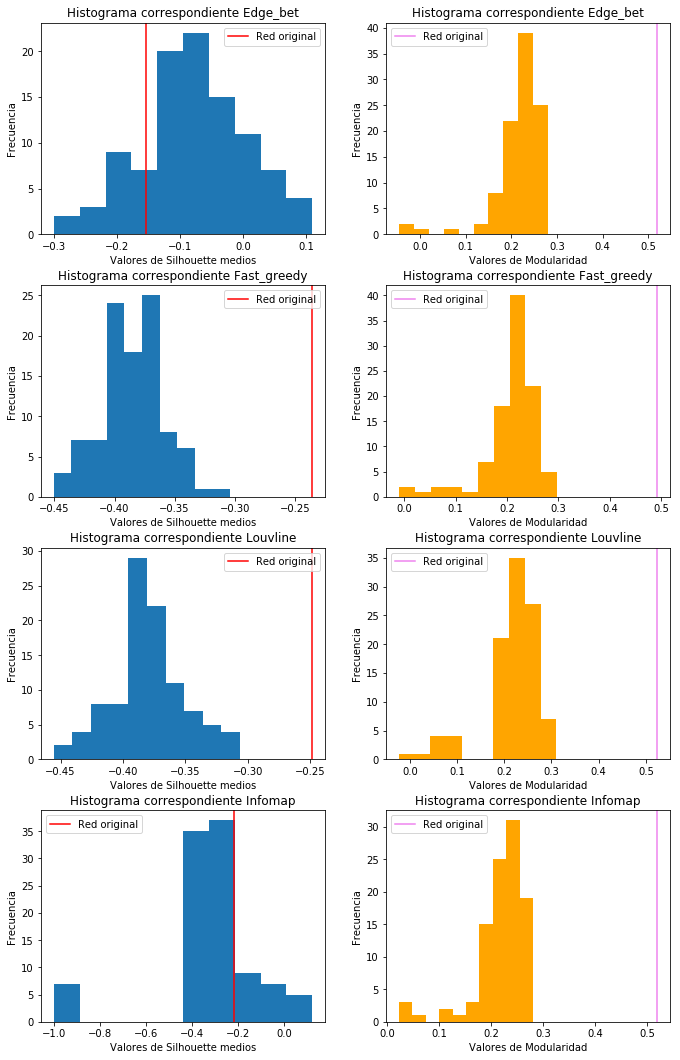

In [15]:
f, axs = plt.subplots(4, 2, figsize=(10,15))
f. tight_layout(pad=3.0)
for n,metodo in enumerate(particiones):
    particion = particiones[metodo]
    lista_media_silhouette,lista_valores_modularidad= silhouette_modularidad_random(Red_delfines,100,array_funciones,n,particion)

    #grafico Silhouette
    axs[n][0].hist(lista_media_silhouette)
    axs[n][0].set_xlabel('Valores de Silhouette medios')
    axs[n][0].set_ylabel('Frecuencia')
    axs[n][0].set_title(f'Histograma correspondiente {metodo}')
    axs[n][0].axvline(Coeficientes[metodo]['Silhouette'], label = 'Red original',c='red')
    axs[n][0].legend()

    #grafico Modularidad
    axs[n][1].hist(lista_valores_modularidad,color = "orange")
    axs[n][1].set_xlabel('Valores de Modularidad')
    axs[n][1].set_ylabel('Frecuencia')
    axs[n][1].set_title(f'Histograma correspondiente {metodo}')
    axs[n][1].axvline(Coeficientes[metodo]['Modularidad'], label = 'Red original',c='violet')
    axs[n][1].legend()

plt.show()

Como se puede observar en los gráficos, la existencia de
comunidades en el grupo de delfines es evidente. 
El coeficiente de Silhouette medio para Edge Betweenness e Infomap no resulta significativamente mayor que el medio. Esto puede tener que ver con la naturaleza de los recableados: para este método se buscaron nuevas particiones, por lo que es esperable que no se evidencie tan claramente la noción de recableado aleatorio como para el recableado de la Modularidad. Por esta misma razón, al obtener una Modularidad significativamente mayor para ambos casos, podemos afirmar que las particiones en dichos algoritmos son modulares.

## Inciso (c)

Vamos a tomar dos medidas para ver la coherencia entre dos particiones:
* **Presición** usando algo similar a la [matriz confusion](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n)
* [**Información mutua**](https://es.wikipedia.org/wiki/Informaci%C3%B3n_mutua) que mide la dependencia mutua de las dos variables, es decir, mide la reducción de la incertidumbre (entropía) de una variable X debido al conocimiento del valor de otra variable de referencia Y.

El primer método consiste en buscar la presición de la nueva partición (test) para eso consideraremos que hay un "error" en la nueva partición cuando se cumplan dos cosas:

* Dos nodos que pertenecen a la misma comunidad de referencia son
asignados a comunidades diferentes
* Dos nodos de diferentes comunidades de referencia son asignados a una
misma comunidad

Para ver la presición nos quedaremos con los casos donde no hubo error. Para eso buscamos dos valores: los nodos que siguen estando en la nueva partición juntos y los nodos que siguen separados.

In [16]:
def matriz_confusion(test, control, cantidad_de_nodos):
    """
    Función que devuelve aciertos de una partición tomando otra como control.
    
    test: array de clusters de nueva partición
    control: array de clusters de partición con la que comparar
    """
    
    mismo_mismo = 0
    mismo_distinto = 0
    distinto_mismo = 0
    distinto_distinto = 0
    
    for par in combinations(range(0, cantidad_de_nodos), 2):
        idx_1, idx_2 = par
        if test[idx_1] == test[idx_2] and control[idx_1] == control[idx_2]:
            mismo_mismo += 1 
        if not test[idx_1] == test[idx_2] and not control[idx_1] == control[idx_2]:
            distinto_distinto += 1
    
    return mismo_mismo + distinto_distinto

def precision(test, control):
    cantidad_de_nodos = len(test)
    aciertos = matriz_confusion(test, control, cantidad_de_nodos)
    pares_totales = cantidad_de_nodos * (cantidad_de_nodos - 1) / 2
    return aciertos / pares_totales

La otra medida que usaremos será información mutua. Para lo mismo usaremos la función [normalized_mutual_info_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) de la libreria Scikit-Learn.

Queremos convertir el diccionario de cada método en un array manteniendo el mismo orden para cada particion.

In [17]:
particiones_listas = {}

for metodo in particiones:
    particiones_listas[metodo] = []
    for nodo in Red_delfines.nodes():
        particiones_listas[metodo].append(particiones[metodo][nodo])

In [18]:
comparaciones = {}
metodos = particiones.keys()

for m_1, m_2 in list(combinations(metodos, 2)):
    par = (m_1, m_2)
    comparaciones[par] = {}
    test = particiones_listas[m_2]
    control = particiones_listas[m_1] 
    comparaciones[par]["Precision"] = precision(test, control)
    comparaciones[par]['Info_mutua'] = info_mutua(test, control) #aritmethic es default

In [19]:
df_coherencia = pd.DataFrame(comparaciones)
df_coherencia.round(3)

Edge_bet                  Fast_greedy         Louvline
           Fast_greedy Louvline Infomap    Louvline Infomap  Infomap
Info_mutua       0.678    0.776   0.772       0.719   0.756    0.840
Precision        0.847    0.900   0.880       0.868   0.863    0.938

La **información mutua** de dos variables es una cantidad que mide la dependencia mutua de las dos variables. Intuitivamente, la información mutua mide la información que X e Y comparten: mide en cuánto el conocimiento de una variable reduce nuestra incertidumbre sobre la otra. 

Por ejemplo, si X e Y son independientes, entonces conocer X no da información sobre Y y viceversa, por lo que su información mutua es cero. En el otro extremo, si X e Y son idénticas entonces toda información proporcionada por X es compartida por Y: saber X determina el valor de Y y viceversa. 

La **precisión** nos da la proporción de aciertos (cuantos delfines fueron correctamente separados o puestos en la misma comunidad) según la cantidad total de pares de delfines. Se aclara que se considera _correcta_ a la partición que se toma como referencia _control_. El valor de la misma es más bajo ~60% de de "aciertos" para Louvline, mientras que las demás particiones tienen valores más altos que el 80%. 

## Inciso (d)

Utilizaremos el [Test de Fischer](https://es.wikipedia.org/wiki/Prueba_exacta_de_Fisher) para cuantificar el acuerdo entre las particiones obteni-
das mediante los algoritmos del inciso (a) y la proporción de género en cada comunidad. De esa manera tratar de establecer hipótesis sobre el comportamiento de los delfines.

Agregamos a la red data del género de los delfines.

In [20]:
nx.set_node_attributes(Red_delfines, gender_dict, 'gender')

In [21]:
nodos = dict(Red_delfines.nodes(data = True))
masculinos = []
femeninos = []
sin_genero = []
for nodo in nodos:
    if gender_dict[nodo] == 'm':
        masculinos.append(nodo)
    if gender_dict[nodo] == 'f':
        femeninos.append(nodo)
    if gender_dict[nodo] == 'NA':
        sin_genero.append(nodo)

Queremos ver la relación entre genéro y las comunidades halladas. 

In [22]:
print(f'Tenemos {round(len(masculinos) / Red_delfines.number_of_nodes() * 100, 2)}% de delfines masculinos, {round(len(femeninos) / Red_delfines.number_of_nodes() * 100, 2)}% de hembras y {round(len(sin_genero) / Red_delfines.number_of_nodes() * 100, 2)}% sin género.')

Tenemos 54.84% de delfines masculinos, 38.71% de hembras y 6.45% sin género.


Queremos ver si las comunidades halladas tienen la distribución de grado que se esperaría al hacer comunidades al azar (similar a las de la red total) o si tienen prevalencia de algún género. 

In [23]:
particiones_con_genero = {}

for metodo in particiones.keys():
    particiones_con_genero[metodo] = defaultdict(list)
    for d in (particiones[metodo], gender_dict): # you can list as many input dicts as you want here
        for key, value in d.items():
            particiones_con_genero[metodo][key].append(value)

In [24]:
dicc_genero_metodo_comunidad = {}

for metodo in particiones_con_genero:
    dicc_genero_metodo_comunidad[metodo] = {}
    cantidad_de_comunidades = max(particiones_con_genero[metodo].values(), key=lambda x: x[0])[0]
    for comunidad in range(0, cantidad_de_comunidades):
        dicc_genero_metodo_comunidad[metodo][comunidad] = {}
        dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] = 0
        dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] = 0
        
        for delfin in particiones_con_genero[metodo]:
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'm':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'] += 1
            if particiones_con_genero[metodo][delfin][0] == comunidad and particiones_con_genero[metodo][delfin][1] == 'f':
                dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres'] += 1

In [25]:
df_genero = pd.concat({k: pd.DataFrame(v) for k, v in dicc_genero_metodo_comunidad.items()}).transpose()
cols = df_genero.columns
for col in cols:
    df_genero[col] = df_genero[col].apply(lambda x: int(x) if x == x else "Nan")
df_genero

Edge_bet         Fast_greedy         Infomap         Louvline        
   Hombres Mujeres     Hombres Mujeres Hombres Mujeres  Hombres Mujeres
0        5       2           8      15       3       2        6       2
1        3      16           9       5       4      13       14       2
2        9       3          17       2       9       3        1       5
3       16       3         Nan     Nan       8       0        9       3
4      Nan     Nan         Nan     Nan      10       2      Nan     Nan

In [26]:
generos_red = [len(masculinos), len(femeninos)]

fisher_dict = {}

for metodo in dicc_genero_metodo_comunidad:
    fisher_dict[metodo] = {}
    for comunidad in dicc_genero_metodo_comunidad[metodo]:
        generos_comu = [dicc_genero_metodo_comunidad[metodo][comunidad]['Hombres'], dicc_genero_metodo_comunidad[metodo][comunidad]['Mujeres']]
        _, pvalue = stats.fisher_exact([generos_comu, generos_red]) 
        fisher_dict[metodo][comunidad] = pvalue

In [27]:
df_fisher = pd.DataFrame.from_dict(fisher_dict)
df_fisher.index.name = 'Comunidad'
df_fisher.round(3)

,Edge_bet,Fast_greedy,Louvline,Infomap
Comunidad,,,,
0,0.693,0.083,0.464,1.000
1,0.001,0.769,0.040,0.014
2,0.347,0.014,0.083,0.347
3,0.054,NaN,0.347,0.043
4,NaN,NaN,NaN,0.188


Las comunidades que presentan un valor del Test de Fischer cercano a uno son grupos que tienen una distribución de género similar a la de la red total.

Por ejemplo, la __comunidad 0 de Infomap__ que tiene 5 delfines macho y 2 hembra tiene una distribución igual a la red real; mientras que la **comunidad 1 de Edge Betweeness**, con 3 hombres y 16 mujeres tiene bastante mayor porcentaje de mujeres que lo esperado.

En general la mayoría de las particiones tiene predominancia de un género, lo que nos lleva a concluir que los delfines tienen cierta tendencia a relacionarse con delfines de su mismo género. Sin embargo, hay grupos donde se respeta la proporción esperada. Cabría analizar, consiguiendo por ejemplo la edad de los delfines, saber si esto se corresponde a la edad de reproducción de los mismos (como una explicacion posible). 

Vemos si los grupos que respetan la proporción de género, en mayor medida, corresponden a los mismos delfines.

In [28]:
delfines_por_comunidad = {}

for metodo in particiones:
    delfines_por_comunidad[metodo] = {}
    for delfin, comunidad in particiones[metodo].items():
        delfines_por_comunidad[metodo].setdefault(comunidad, set())
        delfines_por_comunidad[metodo][comunidad].add(delfin)

In [29]:
comunidades_proporcionadas = []
for metodo in fisher_dict:
    for comunidad in fisher_dict[metodo]:
        if fisher_dict[metodo][comunidad] > 0.5:
            comunidades_proporcionadas.append((metodo, comunidad))  

In [30]:
comunidades_proporcionadas

[('Edge_bet', 0), ('Fast_greedy', 1), ('Infomap', 0)]

In [31]:
intersecciones_proporcionadas = {}

for m_1, m_2 in list(combinations(comunidades_proporcionadas, 2)):
    par = (m_1, m_2)
    delfines_1 = delfines_por_comunidad[m_1[0]][m_1[1]]
    delfines_2 = delfines_por_comunidad[m_2[0]][m_2[1]]
    intersecciones_proporcionadas[par] = len(delfines_1.intersection(delfines_2))

In [32]:
intersecciones_proporcionadas

{(('Edge_bet', 0), ('Fast_greedy', 1)): 0,
 (('Edge_bet', 0), ('Infomap', 0)): 5,
 (('Fast_greedy', 1), ('Infomap', 0)): 0}

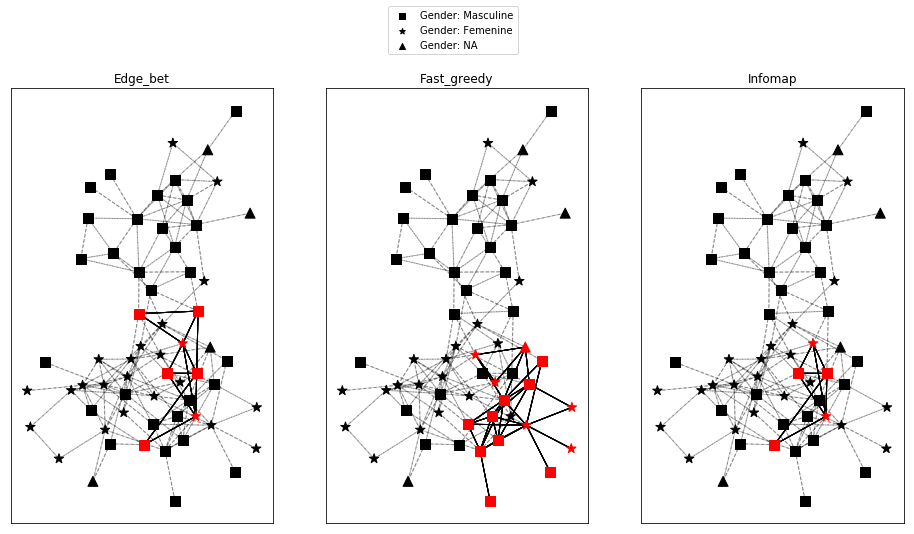

In [33]:
f, axs = plt.subplots(1, 3, figsize=(16,8))
axs = axs.flatten()

metodos = [item[0] for item in comunidades_proporcionadas]

for i,metodo in enumerate(metodos):
    particion = particiones[metodo]
    comunidad_de_interes = [item[1] for item in comunidades_proporcionadas if item[0] == metodo][0]

    node_color_dict = {}
    edge_list_comunidad = []
    edge_list_resto = []
    for node in Red_delfines.nodes():
        if particion[node] == comunidad_de_interes:
            node_color_dict[node] = 'red'
            for edge in Red_delfines.edges(node):
                if edge[1] in delfines_por_comunidad[metodo][comunidad_de_interes]:
                    edge_list_comunidad.append(edge)
                else: 
                    edge_list_resto.append(edge)
        else:
            node_color_dict[node] = 'black'
            edge_list_resto.extend(list(Red_delfines.edges(node)))
            
    for aShape in shapes: 
        
        node_list = [sNode for sNode, attr in Red_delfines.nodes(data = True) if attr['shape'] == aShape]
        node_color = [node_color_dict[sNode] for sNode in node_list]
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = list(edge_list_comunidad), alpha = 1., ax = axs[i])
        nx.draw_networkx_edges(Red_delfines, posiciones, edgelist = edge_list_resto, alpha = 0.1, ax = axs[i], style = 'dashed')
        nx.draw_networkx_nodes(Red_delfines, node_size= 100, ax = axs[i], node_color = node_color,pos=posiciones, node_shape = aShape,  nodelist = node_list)
    
    axs[i].set_title(metodo)
    
    label = {'s': 'Masculine', '*':'Femenine', '^':"NA"}
for aShape in shapes:
    plt.scatter([],[], c = 'black', marker = aShape, label='Gender: {}'.format(label[aShape]))

plt.legend(bbox_to_anchor=(-0.45, 1.2))
plt.show()

Los resultados condicen con lo concluído en el TPC 01 de la materia en el cual mostramos que en esta red en particular hay menos enlaces "hembra - macho" que lo esperado en una red recableada. Es decir, la red presentaba _homofilia_ en la variable género.  

# Ejercicio 2

Queremos otra manera de buscar particiones. En este caso usaremos el método de "percolación de cliques".Un k-clique es un grafo de k nodos completo (con todos los enlaces posibles entre nodos). Un clique implica una noción fuerte de comunidad y se los puede usar como estructuras semillas a partir de las cuales definir comunidades más grandes. 

Los pasos a seguir para el **método de percolación de cliques** son los siguientes:

1. Se elige un valor para k
2. Se encuentran todos los k-cliques de la red
3. Se construye un grafo de cliques, donde dos kcliques estarán vinculados si comparten k-1 nodos.
4. Cada componente conexa de este grafo forma una comunidad



In [34]:
def get_percolated_cliques(G, k):
    if k < 2:
        raise nx.NetworkXError("k=%d, k tiene que ser mayor a 1."%k)
        
    cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)

    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    
    for c1, c2 in combinations(cliques, 2):
        if len(c1.intersection(c2)) >= (k - 1):
            perc_graph.add_edge(c1, c2)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

In [35]:
comunidades_cliques = {}
for k in range(2, max(dict(Red_delfines.degree()).values())):
    comunidades_cliques[k] = {}
    for i, community in enumerate(list(get_percolated_cliques(Red_delfines, k))):
        for dolphin in community:
            comunidades_cliques[k].setdefault(dolphin, [])
            comunidades_cliques[k][dolphin].append(i)   

Este método no asegura poner a cada nodo en una comunidad por lo que borramos los nodos que no tienen una.

In [36]:
empty_keys = [k for k,v in comunidades_cliques.items() if not v]
for k in empty_keys:
    del comunidades_cliques[k]

In [37]:
max_comunidades = 0
max_comunidades_por_delfin = 0

for k in comunidades_cliques.keys():
    #si un nodo esta en mas de una comunidad tiene una lista de comunidades
    comunidades_por_delfin = len(max(comunidades_cliques[3].values(), key = len))
    if comunidades_por_delfin > max_comunidades_por_delfin:
        max_comunidades_por_delfin = comunidades_por_delfin
    
    cantidad_de_comunidades = max([max(comu) for comu in zip(*comunidades_cliques[k].values())]) 
    if cantidad_de_comunidades > max_comunidades:
        max_comunidades = cantidad_de_comunidades
        
        
print(f'La partición con más comunidades tiene {max_comunidades} y un delfín está como mucho en {max_comunidades_por_delfin} comunidades a la vez')

La partición con más comunidades tiene 3 y un delfín está como mucho en 2 comunidades a la vez


In [38]:
def graficar_cliques(particion, ax = None, posiciones = nx.kamada_kawai_layout(Red_delfines), colores = cm.get_cmap('viridis', 5)):
    #Vemos que delfines no tienen comunidad o estan en dos
    nodos_sin_comunidad = set(Red_delfines.nodes()).difference(set(particion.keys()))
    nodos_en_dos = []
    for delfin, comunidad in particion.items():
        if len(comunidad) == 2:
            nodos_en_dos.append(delfin)

    #Vamos con colores segun particion
    colores_list = []
    colores_segunda_comunidad = []
    for nodo in particion.keys():
        if nodo in nodos_en_dos:
            colores_list.append(particion[nodo][1]) #me quedo con el segundo color
            colores_segunda_comunidad.append(particion[nodo][0]) #nos quedamos con el otro

        else: 
            colores_list.append(particion[nodo][0]) 
    #Graficamos los nodos
    
    #Los que tienen comunidad
    nx.draw_networkx_nodes(Red_delfines, posiciones, particion, node_size=300,
                           node_color= colores_list, with_labels = False, ax=ax)
    #Los que estan en dos (asi superponemos colores)
    nx.draw_networkx_nodes(Red_delfines, posiciones, nodos_en_dos, node_size = 100,
                           node_color = colores_segunda_comunidad , alpha = 0.9, ax=ax, vmin = 0, vmax = 4)
    
    #labels a los delfines en dos
    if len(nodos_en_dos) != 0:
        pos_higher = {}
        y_off = 0.05
        x_off = -0.05
        for nodo in nodos_en_dos:
            pos_higher[nodo] = (posiciones[nodo][0], posiciones[nodo][1] + y_off)
        
        nx.draw_networkx_labels(Red_delfines, pos_higher,font_size = 18, labels = {k:k for k in nodos_en_dos}, ax= ax)
    
    #Nodos sin comunidad en negro
    nx.draw_networkx_nodes(Red_delfines, posiciones, nodos_sin_comunidad, node_size = 50,
                           node_color = 'black', alpha = 0.5, ax=ax)

    
    #Graficamos enlaces
    nx.draw_networkx_edges(Red_delfines,pos = posiciones, alpha=0.5, ax=ax)
    
    #Legend de nodos sin comunidad
    ax.scatter([],[], c = 'black', marker = 'o', alpha = 0.7, label= 'Nodos sin comunidad') 

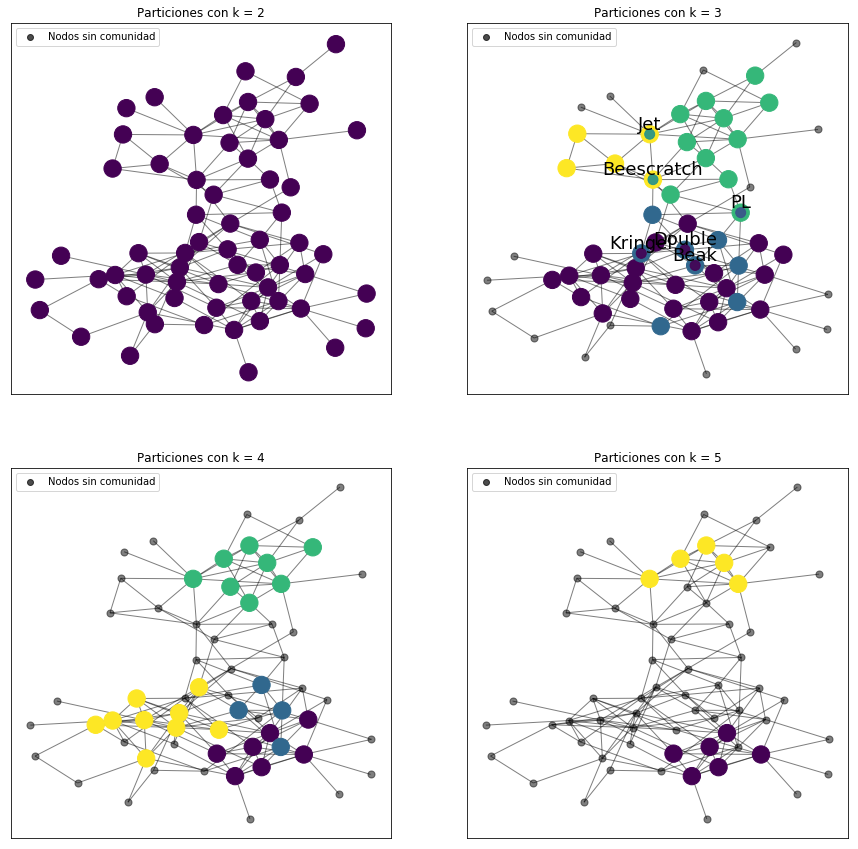

In [39]:
f, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for i,k in enumerate(comunidades_cliques):
    graficar_cliques(comunidades_cliques[k], ax = axs[i])
    axs[i].set_title(f'Particiones con k = {k}')
    axs[i].legend()

Nos quedamos con la partición de k = 3 que agrupa la mayor cantidad de nodos en comunidades. Con k = 2 es un parámetro muy permisivo y todos los delfines quedan en la misma. Podemos encontrar una explicación debido al grado medio de la red. 

In [40]:
grado_medio = 2 * Red_delfines.number_of_edges() / Red_delfines.number_of_nodes()
print(f'El grado medio de la red de delfines {round(grado_medio, 2)}')

El grado medio de la red de delfines 5.13


Para k = 3 hay individuos que no están en comunidades o que están en más de una comunidad, estos son los que tienen dos colores en el gráfico. 

In [41]:
nodos_sin_comunidad = set(Red_delfines.nodes()).difference(set(comunidades_cliques[3].keys()))
porcentaje_sin_comunidad = len(nodos_sin_comunidad) / Red_delfines.number_of_nodes() *100
print(f'Los {len(nodos_sin_comunidad)} delfines que quedan sin comunidad son {nodos_sin_comunidad}, son un {round(porcentaje_sin_comunidad, 2)}% del total.')

Los 16 delfines que quedan sin comunidad son {'TSN83', 'TR88', 'SN89', 'TR120', 'Fork', 'Quasi', 'Whitetip', 'Zig', 'Wave', 'MN23', 'Five', 'SMN5', 'Zipfel', 'TR82', 'Vau', 'Cross'}, son un 25.81% del total.


In [42]:
nodos_en_dos = []
for delfin, comunidad in comunidades_cliques[3].items():
    if len(comunidad) == 2:
        nodos_en_dos.append(delfin)
        
porcentaje_dos_comunidades = len(nodos_en_dos) / Red_delfines.number_of_nodes() *100      

print(f'Los {len(nodos_en_dos)} delfines que quedan en dos comunidades son {nodos_en_dos}, son un {round(porcentaje_dos_comunidades, 2)}% del total.')

Los 6 delfines que quedan en dos comunidades son ['Double', 'Beak', 'Kringel', 'PL', 'Jet', 'Beescratch'], son un 9.68% del total.


A esos delfines los consideraremos los más sociables.

Vamos a analizar algunas características de estos nodos más sociables. Por ejemplo nos interesa saber qué 

In [43]:
centrality = nx.eigenvector_centrality(Red_delfines, max_iter=1000, tol=1e-03)
degree = nx.degree_centrality(Red_delfines)
betweenness = nx.betweenness_centrality(Red_delfines, k = 20)
def close_ig(red):
    G_ig = ig.Graph(directed=True)
    G_ig.add_vertices(list(red.nodes()))
    G_ig.add_edges(list(red.edges()))
    closeness = G_ig.closeness(vertices=None, mode='ALL', cutoff=None, weights=None, normalized=True)
    keys = list(red.nodes())
    close_dict = dict(zip(keys, closeness))
    return close_dict
closeness=close_ig(Red_delfines)


for delfin in nodos_en_dos:
    print(f'{delfin}: {round(closeness[delfin],4)}')

Double: 0.3631
Beak: 0.3466
Kringel: 0.391
PL: 0.3228
Jet: 0.3096
Beescratch: 0.372


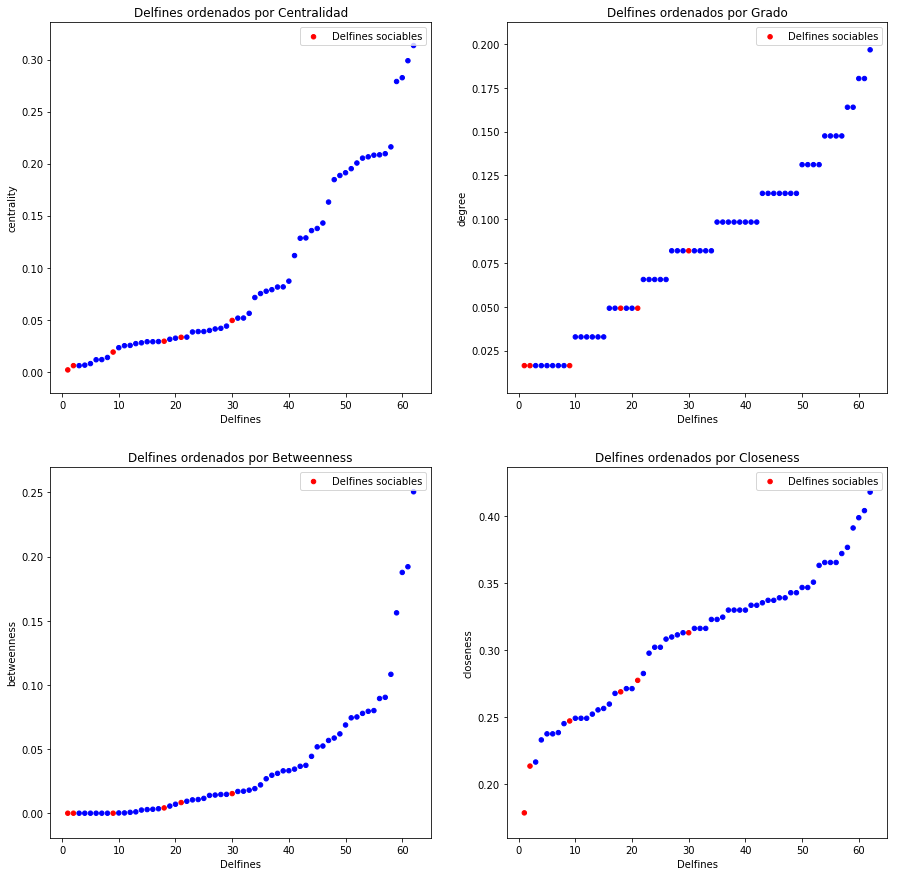

In [44]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
ax = ax.flatten()

d=[centrality,degree,betweenness,closeness]
df=pd.DataFrame(d, index=['centrality', 'degree', 'betweenness','closeness'])
df=df.transpose()
colors = ['r' if dolphin in nodos_en_dos else 'b' for dolphin in df.index]

df=df.sort_values(by=['centrality'])
df['number'] = range(1, len(df) + 1)
df.plot.scatter('number','centrality', color=colors, label='Delfines sociables', ax=ax[0])
ax[0].set_xlabel("Delfines")
ax[0].set_title('Delfines ordenados por Centralidad')

df=df.sort_values(by=['degree'])
df['number'] = range(1, len(df) + 1)
df.plot.scatter('number','degree', color=colors, label='Delfines sociables', ax=ax[1])
ax[1].set_xlabel("Delfines")
ax[1].set_title('Delfines ordenados por Grado')

df=df.sort_values(by=['betweenness'])
df['number'] = range(1, len(df) + 1)
df.plot.scatter('number','betweenness', color=colors, label='Delfines sociables', ax=ax[2])
ax[2].set_xlabel("Delfines")
ax[2].set_title('Delfines ordenados por Betweenness')

df=df.sort_values(by=['closeness'])
df['number'] = range(1, len(df) + 1)
df.plot.scatter('number','closeness', color=colors, label='Delfines sociables' ,ax=ax[3])
ax[3].set_xlabel("Delfines")
ax[3].set_title('Delfines ordenados por Closeness')

plt.show()

Lo que hicimos fue ordenar los delfines de acuerdo a las distintas centralidades y ver qué lugar ocupan estos delfines que son parte de múltiples comunidades.

En los cuatro gráficos notamos que los delfines que pertenecen a dos comunidades están en la mitad inferior (de valores mas bajos) al ser ordenados por centralidad, grado, betweenness y closeness. 

Un resultado interesante es que estos delfines que anteriormente calificamos de "los mas sociables" por pertenecer a múltiples comunidades no corresponden a nodos que puedan destacar por alguna de las centralidades. 

# Ejercicio 3

**Red de coexpresión génica**

Consideramos los datos obtenidos en un estudio de la respuesta transcripcional ante stress de
temperatura sobre una planta (Arabidopsis thaliana). Durante el experimento se sometió a la misma a bajas temperaturas durante dos días, con condiciones de luz controladas.

## Inciso (a)
Encontramos la matriz de correlación entre los perfiles transcripcionales y estimamos a partir de la misma una matriz de similaridad S tal que

$$S_{ij}=\frac{1+cor(A_{i},A_{j})}{2}$$

In [45]:
Data_genes = pd.read_csv('./data/geneX.csv')
Data_genes = Data_genes.T

headers = Data_genes.iloc[0]
Data_genes  = pd.DataFrame(Data_genes.values[1:], columns=headers)

In [46]:
#Correlación entre columnas de un DataFrame
Data_genes = Data_genes.astype(float)
correlaciones = Data_genes.corr(method='pearson', min_periods=1) 
correlaciones.set_index([correlaciones.iloc[0], correlaciones.columns[0]])
correlaciones

Unnamed: 0,AT1G01060,AT1G01120,AT1G01500,AT1G01520,AT1G01580,AT1G02460,AT1G02640,AT1G02820,AT1G04770,AT1G05260,...,AT5G63160,AT5G63600,AT5G64100,AT5G64170,AT5G65010,AT5G66400,AT5G66690,AT5G66740,AT5G67030,AT5G67140
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AT1G01060,1.000000,0.231979,-0.428733,0.916169,0.099693,-0.500882,0.585052,0.751209,-0.757494,-0.165454,...,0.486510,-0.058897,-0.212455,0.088613,0.580779,-0.548548,-0.089202,0.887143,0.587454,0.888658
AT1G01120,0.231979,1.000000,-0.718595,0.449932,0.220159,-0.777605,0.749436,-0.206206,0.018038,0.169543,...,0.884391,0.354795,0.290931,-0.270925,0.556521,-0.568070,0.316805,0.083036,-0.310288,0.394548
AT1G01500,-0.428733,-0.718595,1.000000,-0.465585,-0.083756,0.905592,-0.909657,0.229250,0.423785,0.049670,...,-0.874273,-0.158385,-0.226626,0.630899,-0.863570,0.919465,-0.115490,-0.047366,0.359990,-0.307593
AT1G01520,0.916169,0.449932,-0.465585,1.000000,0.037339,-0.645143,0.648223,0.695317,-0.624236,-0.175154,...,0.625006,-0.055497,-0.272643,0.257792,0.580523,-0.508532,-0.109441,0.852967,0.569699,0.972671
AT1G01580,0.099693,0.220159,-0.083756,0.037339,1.000000,0.029502,-0.016429,-0.001178,0.145582,0.928132,...,0.028625,0.917535,0.838579,-0.172336,-0.102970,-0.281644,0.947694,0.096832,-0.158495,0.041670
AT1G02460,-0.500882,-0.777605,0.905592,-0.645143,0.029502,1.000000,-0.948953,0.085679,0.510217,0.156106,...,-0.926658,-0.082565,-0.064060,0.376472,-0.888307,0.835417,0.004921,-0.180180,0.196827,-0.506397
AT1G02640,0.585052,0.749436,-0.909657,0.648223,-0.016429,-0.948953,1.000000,-0.032494,-0.583743,-0.221371,...,0.908671,0.011012,0.027079,-0.471323,0.952511,-0.871925,-0.043494,0.254589,-0.189900,0.516155
AT1G02820,0.751209,-0.206206,0.229250,0.695317,-0.001178,0.085679,-0.032494,1.000000,-0.406097,-0.162425,...,-0.059676,-0.218336,-0.459527,0.651725,-0.037508,0.099337,-0.218389,0.937843,0.933830,0.783251
AT1G04770,-0.757494,0.018038,0.423785,-0.624236,0.145582,0.510217,-0.583743,-0.406097,1.000000,0.408266,...,-0.362005,0.247881,0.252280,0.202272,-0.747650,0.612590,0.308641,-0.494440,-0.255591,-0.505210


Notamos que la correlacion de un gen consigo mismo es $1$, pero como el objetivo es definir la matriz de similaridad a partir de la correlación y no queremos 'autoloops', entonces definimos como $0$ la similaridad de un gen consigo mismo ($S_{ii}$)

In [47]:
similaridad=(correlaciones+1)/2
np.fill_diagonal(similaridad.values, 0)
similaridad

Unnamed: 0,AT1G01060,AT1G01120,AT1G01500,AT1G01520,AT1G01580,AT1G02460,AT1G02640,AT1G02820,AT1G04770,AT1G05260,...,AT5G63160,AT5G63600,AT5G64100,AT5G64170,AT5G65010,AT5G66400,AT5G66690,AT5G66740,AT5G67030,AT5G67140
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AT1G01060,0.000000,0.615990,0.285634,0.958085,0.549846,0.249559,0.792526,0.875604,0.121253,0.417273,...,0.743255,0.470551,0.393773,0.544306,0.790390,0.225726,0.455399,0.943571,0.793727,0.944329
AT1G01120,0.615990,0.000000,0.140702,0.724966,0.610079,0.111197,0.874718,0.396897,0.509019,0.584771,...,0.942196,0.677397,0.645465,0.364538,0.778260,0.215965,0.658403,0.541518,0.344856,0.697274
AT1G01500,0.285634,0.140702,0.000000,0.267208,0.458122,0.952796,0.045172,0.614625,0.711893,0.524835,...,0.062863,0.420807,0.386687,0.815450,0.068215,0.959733,0.442255,0.476317,0.679995,0.346204
AT1G01520,0.958085,0.724966,0.267208,0.000000,0.518669,0.177428,0.824111,0.847658,0.187882,0.412423,...,0.812503,0.472251,0.363678,0.628896,0.790262,0.245734,0.445279,0.926483,0.784850,0.986336
AT1G01580,0.549846,0.610079,0.458122,0.518669,0.000000,0.514751,0.491786,0.499411,0.572791,0.964066,...,0.514312,0.958767,0.919289,0.413832,0.448515,0.359178,0.973847,0.548416,0.420753,0.520835
AT1G02460,0.249559,0.111197,0.952796,0.177428,0.514751,0.000000,0.025524,0.542840,0.755109,0.578053,...,0.036671,0.458718,0.467970,0.688236,0.055847,0.917709,0.502461,0.409910,0.598413,0.246801
AT1G02640,0.792526,0.874718,0.045172,0.824111,0.491786,0.025524,0.000000,0.483753,0.208128,0.389314,...,0.954335,0.505506,0.513540,0.264338,0.976256,0.064038,0.478253,0.627294,0.405050,0.758077
AT1G02820,0.875604,0.396897,0.614625,0.847658,0.499411,0.542840,0.483753,0.000000,0.296952,0.418787,...,0.470162,0.390832,0.270237,0.825862,0.481246,0.549669,0.390805,0.968922,0.966915,0.891625
AT1G04770,0.121253,0.509019,0.711893,0.187882,0.572791,0.755109,0.208128,0.296952,0.000000,0.704133,...,0.318998,0.623941,0.626140,0.601136,0.126175,0.806295,0.654320,0.252780,0.372205,0.247395


Definiendo la similaridad de esta manera logramos que la similaridad tenga un valor entre $0$ y $1$, donde $0$ representa una correlación negativa perfecta, $1/2$ representa cero correlación y $1$ representa correlación positiva perfecta. 

La idea de este análisis sobre los vectores temporales de transcripción de los genes es que si dos genes tienen un perfil de transcripción parecido, entonces probablemente compartan factores de transcripción. Es decir, esta red de similaridad quiere representar que dos genes se encienden en el mismo entorno. 

Otra manera de pensarlo es que en cierta manera representa la probabilidad de que ambas transcripciones sucedan en simultaneo, si la correlación es perfectamente negativa $\left ( cor(A_{i},A_{j})=-1 \right )$, la probabilidad es nula, y si es perfectamente positiva $\left (cor(A_{i},A_{j})=1\right )$ la probabilidad es $1$.


## b)
Construimos la red de coexpresión génica, utilizando como matriz de adyacencia A una versión
binarizada de la matriz S:

$$a_{ij}=\left \{ _{0 \:\text{ si }\:s_{ij} <  0.95}^{1 \:\text{ si }\: s_{ij}\geq 0.95} \right. $$

In [48]:
ady_arrays=np.where(similaridad >=0.95,1,0)
adyacencia=pd.DataFrame(ady_arrays)
adyacencia

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


## c)
Calculamos la partición en clusters de dicha red mediante los métodos infomap y fastgreedy.

In [49]:
import networkx as nx
import igraph as ig 
import matplotlib.pyplot as plt

Red_genes_nx = nx.from_pandas_adjacency(adyacencia)
Red_genes_igraph = ig.Graph.TupleList(Red_genes_nx.edges(), directed=False)

In [50]:
def convertir_particion_igraph_a_diccionario(Red_igraph,particion_igraph):
    particion_dict = {}
    for cluster in range(len(particion_igraph)):
        for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
            particion_dict.update({nodo:cluster})
    return particion_dict

import random
def colores_hex(n):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])for i in range(n)]
    return color

posiciones = nx.spring_layout(Red_genes_nx)

In [51]:
particiones_genes = {}

#particiones con Fast Greedy
dendograma_fast_greedy = Red_genes_igraph.community_fastgreedy(weights=None)
particiones_fast_greedy = dendograma_fast_greedy.as_clustering()
dict_particiones_fast_greedy = convertir_particion_igraph_a_diccionario(Red_genes_igraph,particiones_fast_greedy)
particiones_genes['Fast_greedy'] = dict_particiones_fast_greedy

#particiones con infomap
particiones_infomap = Red_genes_igraph.community_infomap()
dict_particiones_infomap = convertir_particion_igraph_a_diccionario(Red_genes_igraph,particiones_infomap)
particiones_genes['Infomap'] = dict_particiones_infomap

In [52]:
nodos_sin_comunidad = {}

La partición con Fast_greedy tiene 11 comunidades y 29 nodos sin comunidad.
La partición con Infomap tiene 26 comunidades y 29 nodos sin comunidad.
Los nodos sin comunidad corresponden a nodos que no tienen enlaces. Forman comunidad sólo con ellos mismos


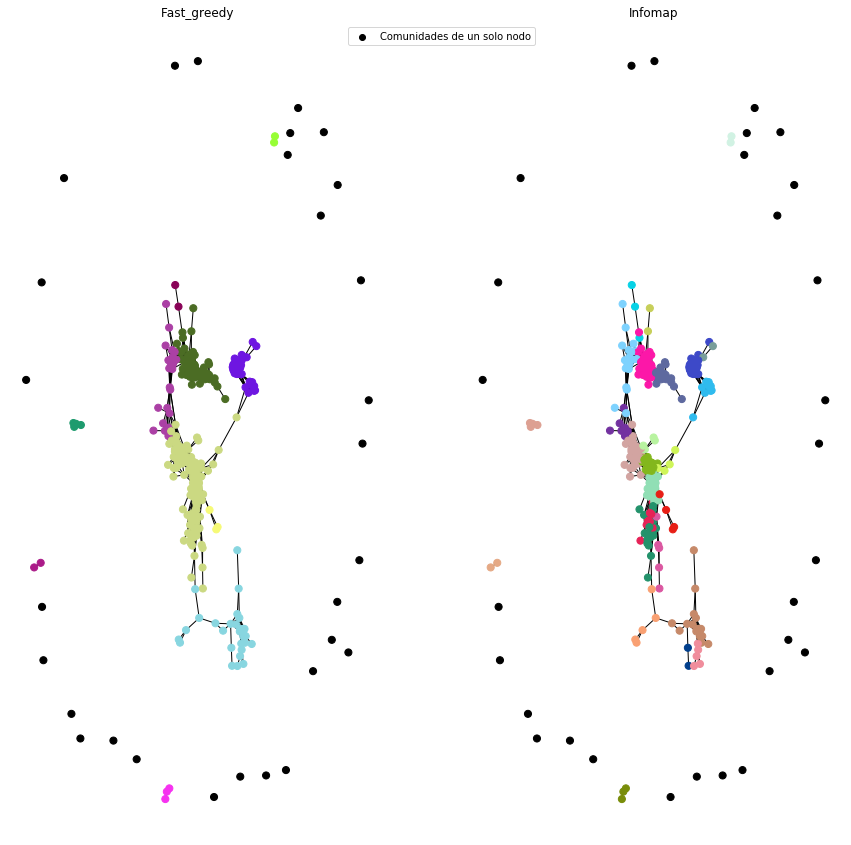

In [53]:
#dendograma_fast_greedy.optimal_count
f, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.flatten()
for i,metodo in enumerate(particiones_genes.keys()):
    particion = particiones_genes[metodo]
    colores = colores_hex(max(particion.values())+1) #funcion que devuelve n colores
    nodos_sin_comunidad[metodo] = set(Red_genes_nx.nodes()).difference(set(particion.keys()))
    print(f'La partición con {metodo} tiene {len(colores)} comunidades y {len(nodos_sin_comunidad[metodo])} nodos sin comunidad.') 
    if metodo == 'Infomap':
        print("Los nodos sin comunidad corresponden a nodos que no tienen enlaces. Forman comunidad sólo con ellos mismos")
    
  # le asigno un color a cada nodo
    node_color = []
    for node in Red_genes_nx.nodes():
        if particion.get(node) is not None:
            node_color.append(colores[particion[node]])
        else:
            node_color.append('black')

    nx.draw(Red_genes_nx, node_size= 50, ax = axs[i], node_color=node_color,pos=posiciones )
    axs[i].set_title(metodo)


plt.scatter([],[], c = 'black', label='Comunidades de un solo nodo')
plt.legend(bbox_to_anchor=(0.2, 1))
plt.show()

Para poder calcular la modularidad, agregamos a las particiones a los nodos sin comunidad asignándoles a cada uno su propia comunidad. 

In [54]:
for metodo in particiones_genes:
    cant_comunidades = (max(particiones_genes[metodo].values())+1)
    for i, node in enumerate(nodos_sin_comunidad[metodo]):
        particiones_genes[metodo][node] = cant_comunidades + i

In [55]:
import community

coeficientes_modularidad = {}
for i,metodo in enumerate(particiones_genes):
    particion = particiones_genes[metodo]
    mod = community.modularity(particion,Red_genes_nx)
    coeficientes_modularidad[metodo]= round(mod, 3)
print(coeficientes_modularidad)

{'Fast_greedy': 0.666, 'Infomap': 0.686}


Para comparar la granularidad de las particiones obtenidas vamos a ver cuántas particiones de cada tamaño quedan al separar en comunidades con estos dos métodos.



AxesSubplot(0.125,0.536818;0.775x0.343182)


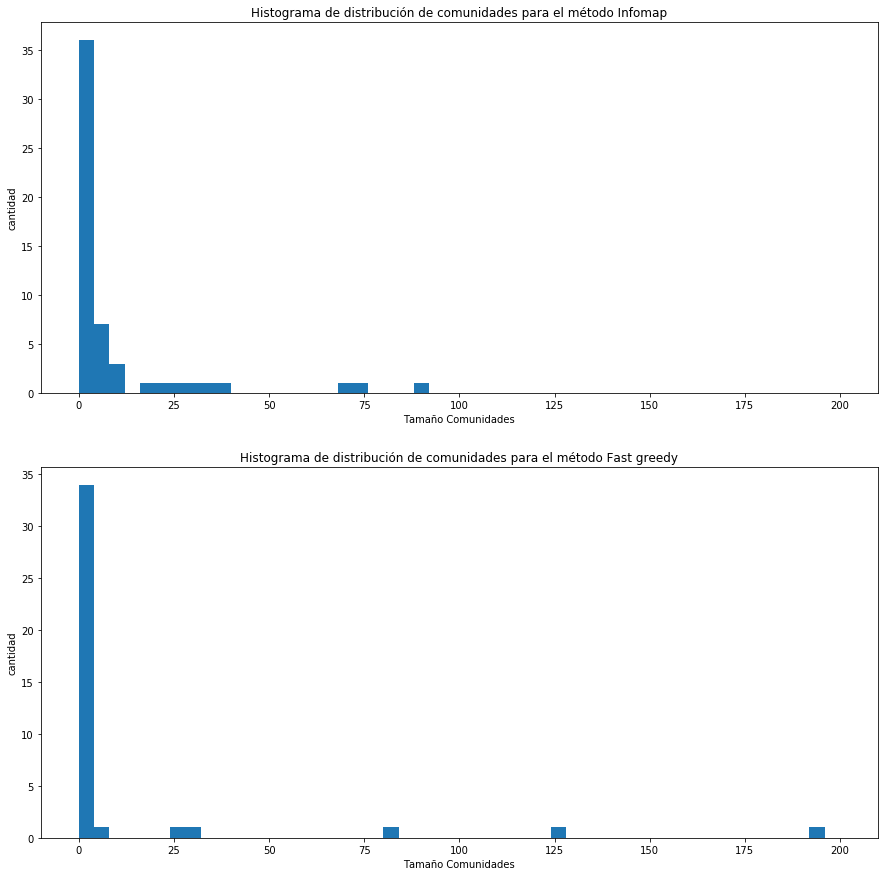

In [56]:
f, ax = plt.subplots(2, 1, figsize=(15,15))
ax = ax.flatten()
print(ax[0])
distribucionComunidades_Infomap=dict(Counter(particiones_genes['Infomap'].values()))
ax[0].hist(distribucionComunidades_Infomap.values(),50,range=(0,200))
ax[0].set_xlabel('Tamaño Comunidades')
ax[0].set_ylabel('cantidad')
ax[0].set_title('Histograma de distribución de comunidades para el método Infomap')
distribucionComunidades_Fast_greedy=dict(Counter(particiones_genes['Fast_greedy'].values()))
ax[1].hist(distribucionComunidades_Fast_greedy.values(),50,range=(0,200))
ax[1].set_xlabel('Tamaño Comunidades')
ax[1].set_ylabel('cantidad')
ax[1].set_title('Histograma de distribución de comunidades para el método Fast greedy')
plt.show()

Para observar un poco mas las comunidades formadas vamos a descartar las comunidades de un solo nodo

In [57]:
distribucionComunidades_Infomap2 = {key:val for key, val in distribucionComunidades_Infomap.items() if val !=1}
distribucionComunidades_Fast_greedy2 = {key:val for key, val in distribucionComunidades_Fast_greedy.items() if val !=1}

AxesSubplot(0.125,0.536818;0.775x0.343182)


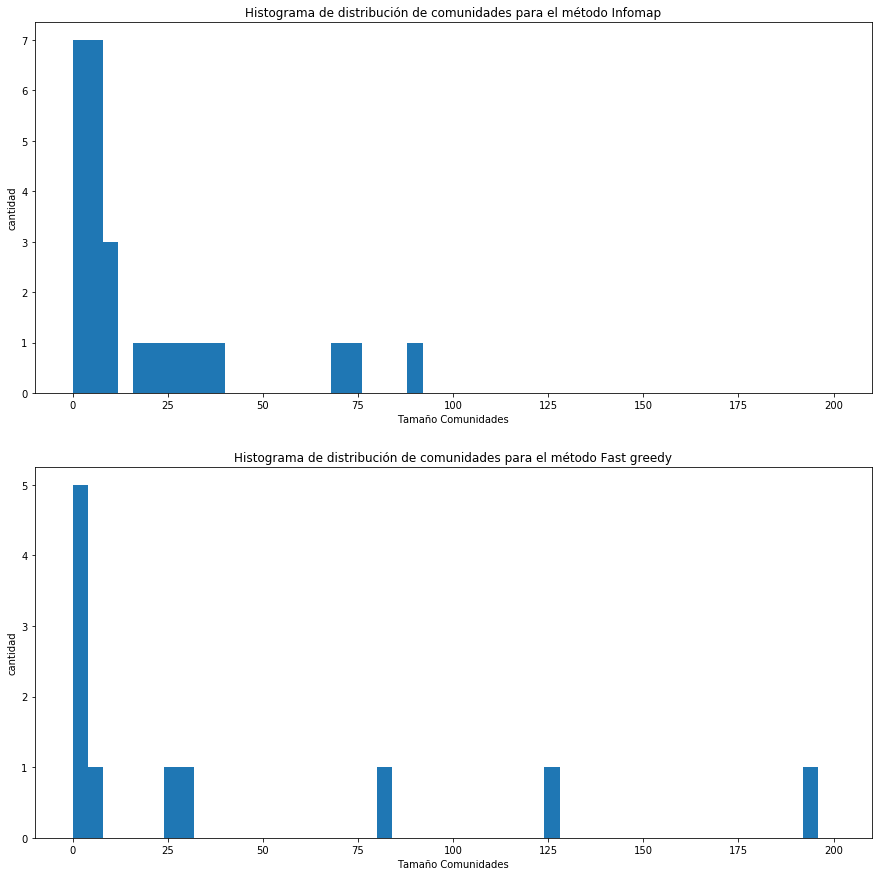

In [58]:
f, ax = plt.subplots(2, 1, figsize=(15,15))
ax = ax.flatten()
print(ax[0])

ax[0].hist(distribucionComunidades_Infomap2.values(),50,range=(0,200))
ax[0].set_xlabel('Tamaño Comunidades')
ax[0].set_ylabel('cantidad')
ax[0].set_title('Histograma de distribución de comunidades para el método Infomap')

ax[1].hist(distribucionComunidades_Fast_greedy2.values(),50,range=(0,200))
ax[1].set_xlabel('Tamaño Comunidades')
ax[1].set_ylabel('cantidad')
ax[1].set_title('Histograma de distribución de comunidades para el método Fast greedy')
plt.show()

Notamos que si bien la diferencia en la modularidad es de $0.02$, la diferencia en la cantidad de comunidades formadas y en sus tamaños es considerable. 

In [59]:
print(f'Los tamaños de las comunidades formadas con el método Infomap son los siguientes:\n{list(distribucionComunidades_Infomap2.values())}\n')
print(f'Los tamaños de las comunidades formadas con el método Fast greedy son los siguientes:\n{list(distribucionComunidades_Fast_greedy2.values())}')

Los tamaños de las comunidades formadas con el método Infomap son los siguientes:
[71, 33, 39, 10, 91, 3, 20, 4, 72, 24, 4, 4, 2, 29, 8, 17, 5, 5, 10, 5, 2, 4, 3, 2, 2, 2]

Los tamaños de las comunidades formadas con el método Fast greedy son los siguientes:
[193, 126, 24, 83, 4, 29, 2, 3, 3, 2, 2]


El método Fast greedy devuelve algunas comunidades mucho mas grandes, pero el npumero total de comunidades es menor. Mientras que el método Infomap devuelve más comunidades de tamaño mas variado.